In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cdms2
import cdutil

In [2]:
f = cdms2.open('/Users/d3x345/NetCDF_files/autoacc_parameterize_new_vocals_unsmoothed25.nc', 'r')
print "f", f
atts = f.attributes.keys()
#print 'global attributes'
for a in f.attributes.keys():
    x = getattr(f,a);
    print 'a', a;
    print 'x', x;
    
dims = f.listdimension();

print dims;
for dim in dims:
    print "dim is ", dim;
    D = f[dim];
    print "D.attributes", D.attributes;
    datts = D.attributes.keys();
    dattv = D.attributes.values();
    print "datts", datts;
    print "dattv", dattv;
    data = D[:];
    t = data.dtype;
    print "type", t;
    print "range: ", data.min(), ":",data.max();

varlist = f.listvariables();

print "varlist is ", varlist;
#for var in varlist:
#    V = f[var][0];
#    print "var", var, V.info();
    

f <CDMS file '/Users/d3x345/NetCDF_files/autoacc_parameterize_new_vocals_unsmoothed25.nc', mode 'r' at 10d1cdb20, status: open>
['dim1_QC', 'dim1_AUTO', 'dim1_ND', 'string', 'structure_elements']
dim is  dim1_QC
D.attributes {'units': ''}
datts ['units']
dattv ['']
type float32
range:  0.0 : 2265.0
dim is  dim1_AUTO
D.attributes {'units': ''}
datts ['units']
dattv ['']
type float32
range:  0.0 : 2265.0
dim is  dim1_ND
D.attributes {'units': ''}
datts ['units']
dattv ['']
type float32
range:  0.0 : 2265.0
dim is  string
D.attributes {'units': ''}
datts ['units']
dattv ['']
type float32
range:  0.0 : 255.0
dim is  structure_elements
D.attributes {'units': ''}
datts ['units']
dattv ['']
type float32
range:  0.0 : 0.0
varlist is  ['AUTO', 'QC', 'ND', 'NAME']


('Nd range', 10.10339, 340.30264, 'Qc range', 0.020454532, 1.0093875, '\n Auto Range', 1.325901804063695e-18, 4.1747767350516368e-08)
('logA range', -41.363289697867074, -17.190470722458976)


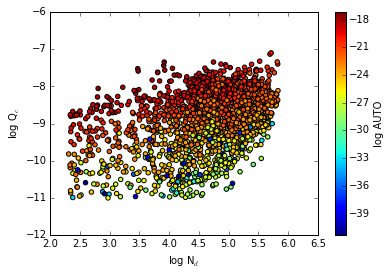

In [3]:
# read in the data, eliminate the extra dimension
Nd = f('ND').squeeze() # rob's email says units are #/cm3
Qc = f('QC').squeeze() # rob's email says units are g/m3
AUTO = f('AUTO').squeeze()  # rob's email says units are kg/m3/s 
condition = AUTO >= 1.e-32
Nd = np.extract(condition,Nd)
Qc = np.extract(condition,Qc)
AUTO = np.extract(condition,AUTO)
#print("condition", condition, np.extract(condition,AUTO).shape)
#print "a",Nd.shape, Nd
#Nd.info()
print ("Nd range", Nd.min(), Nd.max(), "Qc range", Qc.min(), Qc.max(), "\n Auto Range", AUTO.min(), AUTO.max())
rhoair = 1.22 # assumed air density kg/m3
#logN = cdms2.MV.log(Nd*1.e6/rhoair) # convert to log of #/m3 (if rhoair = 1) or #/kg if rhoair != 1
logN = cdms2.MV.log(Nd) # leave in KK2000 units #/cm3
logQ = cdms2.MV.log(Qc*1.e-3/rhoair) # convert to log of kg/m3 (if rhoair = 1) or kg/kg if rhoair != 1
logA = cdms2.MV.log(AUTO/rhoair) # convert to log of kg/kg/s
print("logA range", logA.min(), logA.max())
#plt.scatter(Nd,Qc,c=AUTO)
sc = plt.scatter(logN,logQ,c=logA)
plt.colorbar(sc,label="log AUTO")
plt.xlabel("log N$_d$")
plt.ylabel("log Q$_c$")
plt.show()
#Qc.info()
#AUTO.info()

In [7]:
# see example at http://statsmodels.sourceforge.net/devel/examples/notebooks/generated/ols.html
# note that the following line causes "print" to be treated using Python 3 syntax (as a function) 
from __future__ import print_function
import statsmodels.api as sm
#from statsmodels.sandbox.regression.predstd import wls_prediction_std
#np.random.seed(9876789)

In [4]:
# create an array of logQ and LogN
# X = np.column_stack((logQ, logN))
X = np.column_stack((logN, logQ))
# add a column of 1's to find the constant
X = sm.add_constant(X)
# define the model (logA = a*logQ + b*logN + logK)
# logA = log(Q**a) + log(N**b) + logK
# logA = log(Q**a . N**b . K)
# A =Q**a . N**b . K
model = sm.OLS(logA,X)
# perform the regression
results = model.fit()
print(results.summary())
print(results.params)
logK = results.params[0]
a = results.params[2]
b = results.params[1]
K = np.exp(logK)
print("a, b, logK", a, b, logK)
print("logK and K =",logK, K )
logAf = logK + a*logQ + b*logN
sc2 = plt.scatter(logA,logAf)
#plt.colorbar(sc,label="log AUTO")
plt.xlabel("AUTO$_{SCE}$")
plt.ylabel("fitted AUTO")
print ("min, max logA",logA.min(), logA.max())
plt.show()

NameError: name 'sm' is not defined

(2215,)
(2215,)
min, max A 5.79244e-13 3.54261e-08


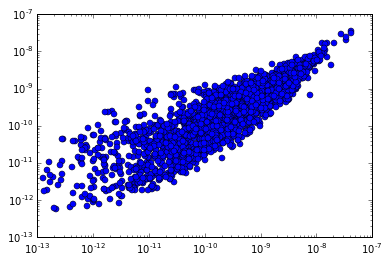

In [66]:
AUTOf = cdms2.MV.exp(logAf)*rhoair
print(np.shape(AUTOf))
print(np.shape(AUTO))
ax = plt.gca()
x = np.asarray(AUTO)
y = np.asarray(AUTOf)
ax.plot(x,y,'o',c='blue')
ax.set_yscale('log')
ax.set_xscale('log')
#plt.colorbar(sc,label="log AUTO")
#ax.xlabel("AUTO$_{SCE}$")
#ax.ylabel("fitted AUTO")
print ("min, max A",AUTOf.min(), AUTOf.max())